## How to fit a line to data

Line fitting is ubiquitous in the natural and physical sciences.

However in the cases we are often taught to learn line-fitting techniques, the data are not realistic. In a field like astronomy, which is based on remote-sensing, the most typical case for our data has both $x$ and $y$ coordinates with uncertainties, as well as truncation due to instrumental limits. In fact, the uncertanties themselves are often poorly known (i.e., there is error on the error).

The likelihood is the probability (density) with which we would expect the observed data to occur conditional on the parameters of the model that we look at. 

The model is some relationship that we expect to generate the data and all of its observed nastiness.

Given a simple linear model, such as: $$y = \beta + \alpha*x,$$ a linear regression analysis takes the parameters (a, b) as input to the linear model to generate an expected y value. This expectation is then compared to the real data, given some additional prior information about those parameters, and produces a probability of this model fitting the data.

For the model, which we call $\mid M$, $p$ is the likelihood function, $p(D \mid M)$; the initial assumption of the distribution of $P$ is the prior, $P(M)$; the denominator is the marginal likelihood or evidence; and the final result is the posterior probability, $P(M \mid D)$, all of which are related by Bayes' Theorem:

$$ P(M \mid D) = \frac{p(D \mid M) P(M)}{p(D)} $$

For estimating parameters in a Bayesian analysis, we need to define a likelihood function, as well as a model that describes the data (entirely). 

In the world of Bayesian statistics, we are solving for the probability of observing a model given some (noisy) data. However, for any realization of this model, one must account for statistical error in the comparison. That's what differentiates likeihoods from probabilities: likeihoods represent an unnormalized probability of observing the data given some specific model. In practice, it is common for people to assume Gaussian statistics, such that the comparison is based on a $\chi^2$ statistic.

Some references on MCMC and Bayesian Statistics:
https://www.amazon.com/Handbook-Chapman-Handbooks-Statistical-Methods/dp/1420079417

Some references on PYMC:
https://pymc-devs.github.io/pymc/
https://people.duke.edu/~ccc14/sta-663/PyMC2.html
http://stronginference.com/

Other good reads:
https://normaldeviate.wordpress.com/2012/11/17/what-is-bayesianfrequentist-inference/
http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf

## Begin the tutorial

import some libraries that we will need:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # Needed stats.linregress
import statsmodels.api as sm # sm.OLS
import bces  #https://github.com/rsnemmen/BCES
import pymc # for pymc
from pymc import AdaptiveMetropolis  
import seaborn
from astroML.linear_model import TLS_logL
from scipy import optimize
from astroML.plotting.mcmc import convert_to_stdev

/usr/local/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Create the true underlying dataset

Let's use a very simple linear model. Afterwords, we will add some measurement error (y_std)

In [2]:
np.random.seed(50)
#intercept = 25 and slope = 0.5
theta_true = (25, 0.5)
#xtrue = 100 * np.random.random(1000) #Choose a Uniform distribution in x
xtrue = np.random.normal(40,10,size=100) #Choose a Gaussian distribution in x
ytrue = theta_true[0] + theta_true[1] * xtrue 

(0, 100)

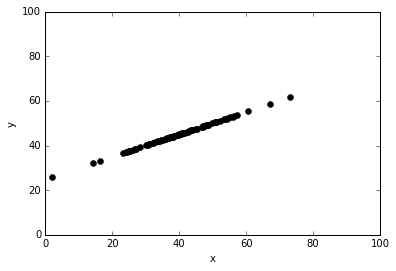

In [3]:
plt.plot(xtrue, ytrue, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,100)
plt.ylim(0,100)

# Data 1

Now, create the other observable, where the y values are scattered due to a single measurement error (i.e., there is no hidden parameter which would cause one measurement to be an inherently noisier estimate than any other).

This also means that all of the data points would have the same "error bar", which is a Gaussian of width y_std.

You can think of this as experimental statistical error. We will address systematic errors later.

### Add noise to y

In [4]:
#Option 1 is a variable error defined on its own. With some maximum
y_std = 0
while (y_std < 15):
    y_std = 20*np.random.random(1)
#Option 2 is a fixed error depending on a Gaussian around the mean of the data:
y_std = 5
ydata = np.random.normal(ytrue,y_std)
ydata_err = np.zeros(len(ytrue)) + y_std
#We ignore error in x for now
xdata = xtrue
xtrue1= xtrue
xdata_err =  np.zeros(len(xtrue)) 
# Redefine some names of the data
xdata1_err = xdata_err
ydata1_err = ydata_err
xdata1 = xdata
ydata1 = ydata
#Add some outliers
#s = np.random.standard_t(0.5,size=len(ydata))
#ydata = ydata + s

Now, let's mess with this data even more. For instance, most of Astronomy has flux-limited data (i.e., out instruments can only observe data down to some noise limit). So let's apply a cut to the data (on these x and y-values).

### Truncate the y data

In [5]:
limit = np.where((ydata > 40) & (ydata < 100))[0]
keep =  np.random.randint(0, len(xtrue),size=len(limit))

Here is our noisy data (the red line is the model):

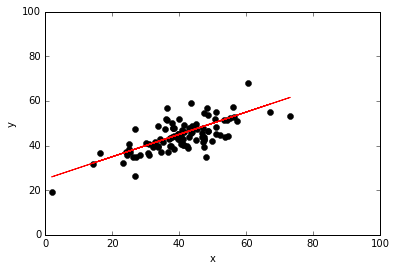

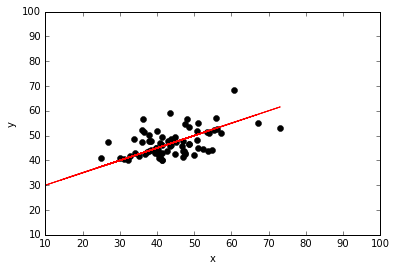

In [6]:
plt.plot(xdata1, ydata1, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,100)
plt.ylim(0,100)
y_hat = theta_true[0] + theta_true[1]*xdata1
plt.plot(xdata1,y_hat,color='r')
plt.show()
plt.plot(xdata1[limit], ydata1[limit], 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(10,100)
plt.ylim(10,100)
y_hat = theta_true[0] + theta_true[1]*xdata1
plt.plot(xdata,y_hat,color='r')

For now, we assume that all of the data points would have the same "error bar", which is a Gaussian of width y_std. You can think of this as experimental statistical error. We will address systematic errors later.

Now, let's do a simple linear regression and ignore the error bars:

# Begin the linear Regressions

### Standard frequentists techniques

In [213]:
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata1,ydata1)
print 'No flux limit: ', slope, intercept, std_err
y_fit = intercept + slope*(xdata1)

slope, intercept, r_value, p_value, std_err = stats.linregress(xdata1[limit],ydata1[limit])
print 'With flux limit: ', slope, intercept,std_err
y_fit_wlim = intercept + slope*(xdata1[limit])

No flux limit:  0.463169899678 25.5087256175 0.0473200415886
With flux limit:  0.302131535122 33.8494111379 0.064161677263


How about Ordinary Least Squares?

In [160]:
x = sm.add_constant(xdata1) # constant intercept term
y = ydata1
# Model: y ~ x + c
model = sm.OLS(y, x)
fitted = model.fit()
x_pred = np.linspace(x.min(), x.max(), 50)
x_pred2 = sm.add_constant(x_pred)
y_pred = fitted.predict(x_pred2)
rho = fitted.params
print 'OLS intercept and slope: ', rho

OLS intercept and slope:  [ 25.50872562   0.4631699 ]


In [161]:
#Now on the flux limited data
x= sm.add_constant(xdata1[limit]) # constant intercept term
y = ydata1[limit]
# Model: y ~ x + c
model = sm.OLS(y, x)
fitted = model.fit()
x_pred_wlim = np.linspace(x.min(), x.max(), 50)
x_pred2_wlim = sm.add_constant(x_pred_wlim)
y_pred_wlim = fitted.predict(x_pred2_wlim)
rho = fitted.params
print 'OLS intercept and slope (flux limited): ', rho

OLS intercept and slope (flux limited):  [ 33.84941114   0.30213154]


Note that both stats.linregress and sm.OLS are least squared regression models. They should return identical results.

There are fitting routines which allow easy accounting of error bars, like bivariate correlated errors and intrinsic scatter. For example go to: https://github.com/rsnemmen/BCES or read: http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/9605002

In [220]:
nboot = 10000
cov = np.zeros(len(xdata1_err))
a,b,erra,errb,covab=bces.bcesp(xdata1,xdata1_err,ydata1,ydata1_err,cov,nboot)
x=np.linspace(xdata1.min(),xdata1.max())
y_fit_bces = a[3]*xdata1+b[3]
#note that the third axis of the fit contains the orthogonal constraints.
print 'Bisector: ', a[3], b[3]

BCES, 10000 trials... 
2.928313 s
Bisector:  0.459937159884 25.6271857412


Now let us try BCES on the flux limited data:

In [221]:
nboot = 10000
cov = np.zeros(len(xdata1_err[limit]))
a,b,erra,errb,covab=bces.bcesp(xdata1[limit],xdata1_err[limit],ydata1[limit],ydata1_err[limit],cov,nboot)
x=np.linspace(xdata1[limit].min(),xdata1[limit].max())
y_fit_bces_wlim = a[3]*xdata1[limit]+b[3]
#note that the third axis of the fit contains the orthogonal constraints.
print 'Bisector (with flux limits): ', a[3], b[3]

BCES, 10000 trials... 
3.480628 s
Bisector (with flux limits):  0.289036504591 34.424784251


AstroML provides an Errors-in-Variables base code to do the same thing as BCES, but with a different consideration of the slope (i.e., a linear regression prior). 

We now follow this reference to employ an errors-in-variables analysis: http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html

Optimization terminated successfully.
         Current function value: 292.204152
         Iterations: 122
         Function evaluations: 254


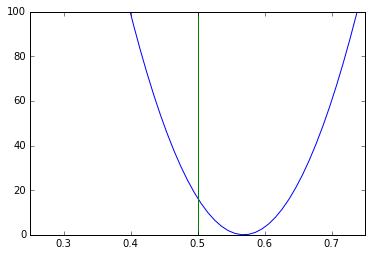

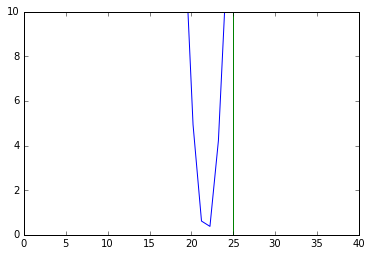

No flux limit:  0.554718456568 21.8101262487


In [222]:
rho_xy = np.zeros(len(xdata1))
X = np.vstack((xdata1, ydata1)).T
dX = np.zeros((len(xdata1), 2, 2))
dX[:, 0, 0] = xdata1_err ** 2
dX[:, 1, 1] = ydata1_err ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * xdata1_err * ydata1_err
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[-1, 1],xtol=1e-10,maxiter=100000)

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
m_fit, b_fit = get_m_b(beta_fit)
#x=np.linspace(xdata.min(),xdata.max())
y_fit_eiv = m_fit*xdata1+b_fit

# plot the likelihood ratio contour in m, b
# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])
m = np.linspace(0,1, 100)
b = np.linspace(0, 100, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)
        if np.isnan(logL[i,j]):
            logL[i, j] = -9e12
plt.plot(np.linspace(0,1,100),np.max(logL) -  logL[:,np.int(b_fit)])
plt.plot([theta_true[1],theta_true[1]], [0,100])
plt.ylim(0,100)
plt.xlim(0.25,0.75)
plt.show()
plt.plot(np.linspace(0,100,100),np.max(logL) -  logL[np.int(100*m_fit),:])
plt.plot([theta_true[0],theta_true[0]], [0,100])
plt.ylim(0,10)
plt.xlim(0,40)
plt.show()
print 'No flux limit: ', m_fit, b_fit


Now we conduct an Errors-in-Variables analysis on the flux limited data

Optimization terminated successfully.
         Current function value: 214.618347
         Iterations: 140
         Function evaluations: 287


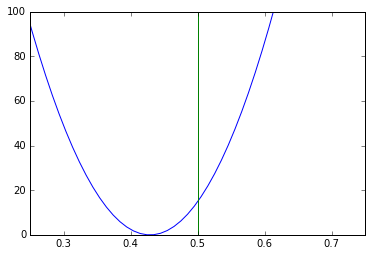

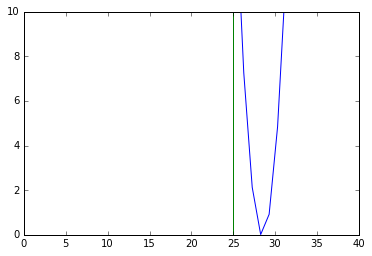

With flux limit:  0.425480753552 28.4304921432


In [224]:
rho_xy = np.zeros(len(xdata1[limit]))
X = np.vstack((xdata1[limit], ydata1[limit])).T
dX = np.zeros((len(xdata1[limit] ), 2, 2))
dX[:, 0, 0] = xdata1_err[limit] ** 2
dX[:, 1, 1] = ydata1_err[limit] ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * xdata1_err[limit] * ydata1_err[limit]
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[-1, 1],xtol=1e-10,maxiter=100000)

m_fit, b_fit = get_m_b(beta_fit)
#x=np.linspace(xdata.min(),xdata.max())
y_fit_eiv_wlim = m_fit*xdata1[limit]+b_fit

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)
        if np.isnan(logL[i,j]):
            logL[i, j] = -9e12
plt.plot(np.linspace(0,1,100),np.max(logL) -  logL[:,np.int(b_fit)])
plt.plot([theta_true[1],theta_true[1]], [0,100])
plt.ylim(0,100)
plt.xlim(0.25,0.75)
plt.show()
plt.plot(np.linspace(0,100,100),np.max(logL) -  logL[np.int(100*m_fit),:])
plt.plot([theta_true[0],theta_true[0]], [0,100])
plt.ylim(0,10)
plt.xlim(0,40)
plt.show()
print 'With flux limit: ', m_fit, b_fit

E-in-V works reasonably well. The slope is recovered within the likelihood contours. The amplitude not so much.

Now, let's move to a Bayesian implementation of linear regression. I will need to define some helper functions and I am using PYMC.

### Bayesian Techniques

In [11]:
# Create some convenience routines for plotting
# Taken from: http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
#The output of the MCMC algorithm is a trace, the sequence of retained samples for each variable in the model. These traces can be accessed using the trace(name, chain=-1) method. 
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_results(xdata, ydata, trace,alpha,beta, colors='r'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace,alpha,beta)

def plot_MCMC_results2(xdata, ydata, trace,alpha,beta, colors='r'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model2(ax[1], xdata, ydata, trace,alpha,beta)
    
def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.002)
    ax.contour(xbins, ybins, sigma.T,levels=[0.683, 0.955],zorder=3, **kwargs)
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.plot([theta_true[0],theta_true[0]], [theta_true[1],theta_true[1]], 'x',color='green', ms=10)
    
    
def plot_MCMC_model(ax, xdata, ydata, trace,alpha, beta):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')
    mcmc_alpha, mcmc_beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = mcmc_alpha[:, None] + mcmc_beta[:, None] * xfit
    sig = 2 * yfit.std(0)
    mu = alpha + beta * xfit
    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(10,90)
    ax.set_ylim(10,90)
    y_hat = theta_true[0] + theta_true[1]*xtrue
    ax.plot(xtrue,y_hat, linestyle='dotted', color='r' )
    
def plot_MCMC_model2(ax, xdata, ydata, trace,alpha,beta):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')
    mcmc_alpha, mcmc_beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = mcmc_alpha[:, None] + mcmc_beta[:, None] * xfit
    sig = 2 * yfit.std(0)
    mu = alpha + beta * xfit
    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-10,100)
    ax.set_ylim(-10,100)
    y_hat = theta_true[0] + theta_true[1]*xtrue
    ax.plot(xtrue,y_hat, linestyle='dotted', color='r' )

Run a Bayesian analysis. Assume only errors on the y-axis data. Use a linear regression prior on $\beta$. A uniform prior on $\alpha$. Treat the errors as deterministic from a uniform draw on the true y errors. Model the likelihood as a Normal.

In [262]:
# Define the variables needed for the routine, with their prior distributions
alpha1 = pymc.Uniform('alpha1', 0, 100)

# Thrprior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf
   
@pymc.stochastic(observed=False)
def beta1(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma1_yi = pymc.Uniform('sigma1_yi',0,100, value=ydata1_err[limit])
@pymc.deterministic 
def tau1_yi(sigma1_yi=sigma1_yi): 
            return 1./sigma1_yi**2.  
    
# Define the form of the model and likelihood
@pymc.deterministic
def y_model1(x=xdata1[keep], alpha1=alpha1, beta1=beta1):
    fit = alpha1 + beta1*x
    return fit

# Define the likelihood (as Normal)
y1 = pymc.Normal('y1', mu=y_model1, tau=tau1_yi, observed=True, value=ydata1[keep])
# package the full model in a dictionary.
#We're going to call this model1
model1 = dict(alpha1=alpha1, beta1=beta1, tau1_yi=tau1_yi,
              y_model1=y_model1, y1=y1)

Run the sampler. Use Adaptive Metropolis sampling, since it is more efficient when parameters are correlated. Note that in linear regression, the slope and amplitude are always highly correlated.

I am going to use "burn-ins" in this tutorual to determine the best place to start the MCMC chain. However, there is no concensus on whether this is the correct approach. Arguably, a better approach is using a really good linear regression fit result. For instance, see:
http://stronginference.com/burn-in-and-other-mcmc-folklore.html

In [263]:
S1 = pymc.MCMC(model1)
# Using AdapativeMetropolis, since alpha and beta are correlated
S1.use_step_method(AdaptiveMetropolis,S1.alpha1)
S1.use_step_method(AdaptiveMetropolis,S1.beta1)
S1.sample(iter=1000000, burn=100000,thin=100)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 126.3 sec

alpha and beta values at maximum: 24.643 ,0.501
alpha values around median (2 sig): 24.579  -3.711 +3.803
beta values around median (2 sig): 0.503  -0.095 +0.091
BIC=  468.284050936


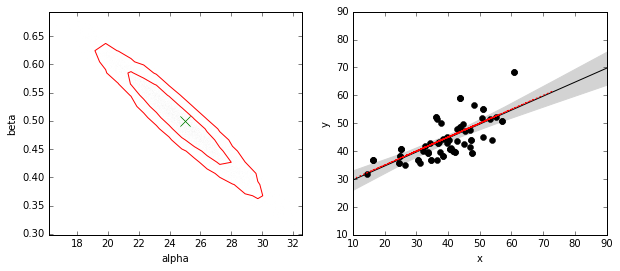

In [270]:
pymc_trace1 = [S1.trace('alpha1')[:],
               S1.trace('beta1')[:],
               S1.trace('tau1_yi')[:]]
alpha1_median =  np.median(S1.trace('alpha1')[:])
alpha1_05 = np.percentile(S1.trace('alpha1')[:], 5)
alpha1_33 = np.percentile(S1.trace('alpha1')[:], 33)
alpha1_67 = np.percentile(S1.trace('alpha1')[:], 67)
alpha1_95 = np.percentile(S1.trace('alpha1')[:], 95)
beta1_median =  np.median(S1.trace('beta1')[:])
beta1_05 = np.percentile(S1.trace('beta1')[:], 5)
beta1_33 = np.percentile(S1.trace('beta1')[:], 33)
beta1_67 = np.percentile(S1.trace('beta1')[:], 67)
beta1_95 = np.percentile(S1.trace('beta1')[:], 95)
fitter1 = pymc.MAP(model1)
fitter1.fit(iterlim=1000)
alpha1_map = np.float(fitter1.alpha1.value)
beta1_map = np.float(fitter1.beta1.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha1_map), ',{0:5.3f}'.format(beta1_map)
print "alpha values around median (2 sig): {0:5.3f}".format(alpha1_median), " -{0:5.3f}".format(alpha1_median-alpha1_05), "+{0:5.3f}".format(alpha1_95-alpha1_median)
print "beta values around median (2 sig): {0:5.3f}".format(beta1_median), " -{0:5.3f}".format(beta1_median-beta1_05), "+{0:5.3f}".format(beta1_95-beta1_median)
BIC1 =  fitter1.BIC
print 'BIC= ', BIC1
plot_MCMC_results(xdata1[keep], ydata1[keep], pymc_trace1,alpha1.value,beta1.value)
y_fit1 = alpha1.value + xdata1*beta1.value

PYMC provides a function to examine the chains (top left), autocorrelaton (bottom left) and histograms of traces.

Use the traces and the autocorrelation plots to see if the MCMC has converged (stable chain and low autocorrelation).

Plotting alpha1
Plotting beta1


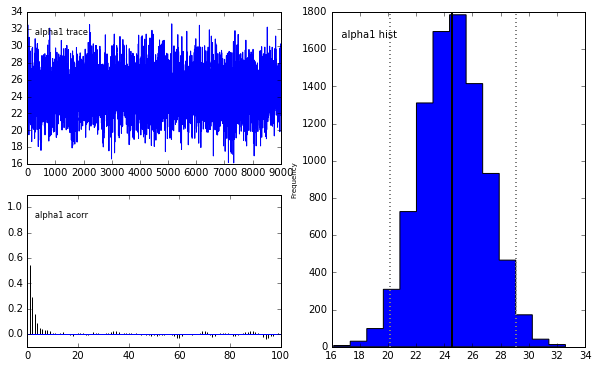

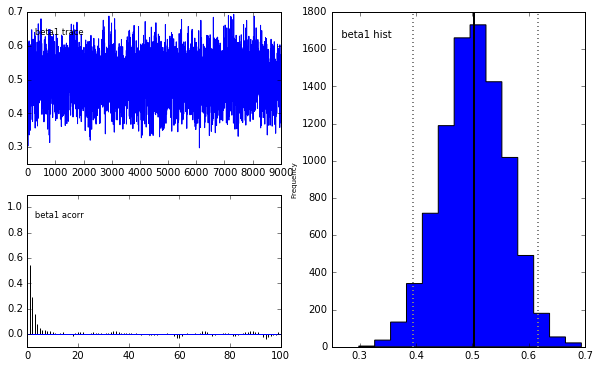

In [267]:
pymc.Matplot.plot(S1)

Conclusion: The Bayesian model works pretty well on the noisy but un-truncated data.

Now, run the nominal Bayesian model against the truncated data.

In [271]:
# Define the variables needed for the routine, with their prior distributions
alpha2 = pymc.Uniform('alpha2', -100, 100)
# Thr prior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf

    
@pymc.stochastic(observed=False)
def beta2(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma2_yi = pymc.Uniform('sigma2_yi',0,100, value=ydata1_err[limit])
@pymc.deterministic 
def tau2_yi(sigma2_yi=sigma2_yi): 
            return 1./sigma2_yi**2.  

    
# Define the form of the model and likelihood
@pymc.deterministic
def y_model2(x=xdata1[limit], alpha2=alpha2, beta2=beta2):
    fit = alpha2 + beta2*x
    return fit

y2 = pymc.Normal('y2', mu=y_model2, tau=tau2_yi, observed=True, value=ydata1[limit])
#We call this model2
model2 = dict(alpha2=alpha2, beta2=beta2, tau2_yi=tau2_yi,
              y_model2=y_model2, y2=y2)

In [272]:
S2 = pymc.MCMC(model2)
S2.use_step_method(AdaptiveMetropolis,S2.alpha2)
S2.use_step_method(AdaptiveMetropolis,S2.beta2)
S2.sample(iter=1000000, burn=100000,thin=10)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 129.9 sec

alpha and beta values at maximum: 32.718 ,0.328
alpha values around median (1 sig): 33.982  -1.354 +1.359
beta values around median: (1 sig) 0.299  -0.031 +0.030
BIC=  447.013278512


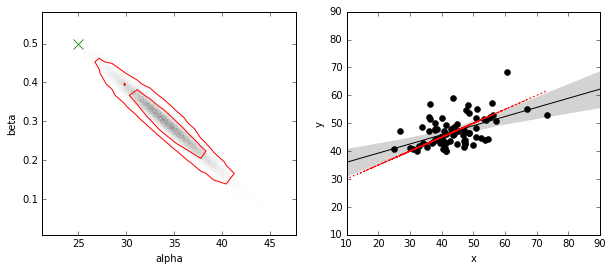

In [273]:
pymc_trace2 = [S2.trace('alpha2')[:],
              S2.trace('beta2')[:],
              S2.trace('tau2_yi')[:]]
alpha2_median =  np.median(S2.trace('alpha2')[:])
alpha2_33 = np.percentile(S2.trace('alpha2')[:], 33)
alpha2_67 = np.percentile(S2.trace('alpha2')[:], 67)
beta2_median =  np.median(S2.trace('beta2')[:])
beta2_33 = np.percentile(S2.trace('beta2')[:], 33)
beta2_67 = np.percentile(S2.trace('beta2')[:], 67)
fitter2 = pymc.MAP(model2)
fitter2.fit(iterlim=1000)
alpha2_map = np.float(fitter2.alpha2.value)
beta2_map = np.float(fitter2.beta2.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha2_map), ',{0:5.3f}'.format(beta2_map)
print "alpha values around median (1 sig): {0:5.3f}".format(alpha2_median), " -{0:5.3f}".format(alpha2_median-alpha2_33), "+{0:5.3f}".format(alpha2_67-alpha2_median)
print "beta values around median: (1 sig) {0:5.3f}".format(beta2_median), " -{0:5.3f}".format(beta2_median-beta2_33), "+{0:5.3f}".format(beta2_67-beta2_median)
BIC2 =  fitter2.BIC
print 'BIC= ', BIC2
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace2,alpha2_map,beta2_map)
y_fit2 = alpha2_map + xdata1[limit]*beta2_map

Check to see if it has converged (yes). Note that above (and from now on) I report 1 sigma errors (or 33% and 67 percentiles to be precise). Matplot reports 5% and 95% (2 sig).

Plotting beta2
Plotting alpha2


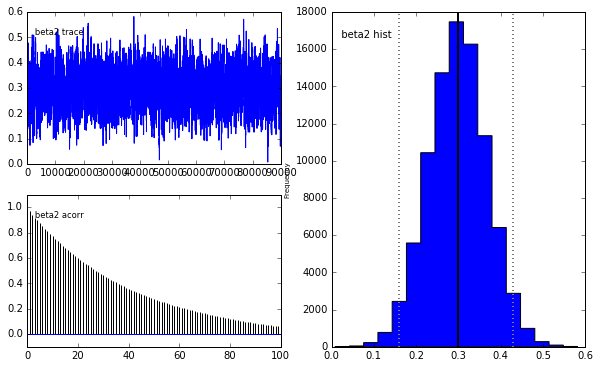

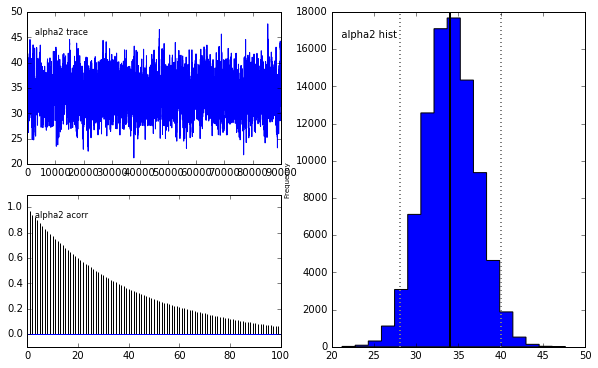

In [274]:
pymc.Matplot.plot(S2)

The Bayesian model fails. Now, try using a slightly different model. Include a Truncated Gaussian on the y

In [21]:
alpha3 = pymc.Uniform('alpha3', -100, 100)

@pymc.stochastic(observed=False)
def beta3(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma3_yi = pymc.Uniform('sigma3_yi',0,100, value=ydata1_err[limit])
@pymc.deterministic 
def tau3_yi(sigma3_yi=sigma3_yi): 
            return 1./sigma3_yi**2.  

    
# Define the form of the model and likelihood
@pymc.deterministic
def y_model3(x3=xdata1[limit], alpha3=alpha3, beta3=beta3):
    fit = alpha3 + beta3*x3
    return fit

y3 = pymc.TruncatedNormal('y3', y_model3, tau3_yi, 40,110,observed=True, value=ydata1[limit])
# package the full model in a dictionary
model3 = dict(alpha3=alpha3, beta3=beta3, tau3_yi=tau3_yi,
              y_model3=y_model3, y3=y3)

In [22]:
S3 = pymc.MCMC(model3)
S3.use_step_method(AdaptiveMetropolis,S3.alpha3)
S3.use_step_method(AdaptiveMetropolis,S3.beta3)
S3.sample(iter=1000000, burn=100000)

/usr/local/anaconda/lib/python2.7/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


 [-----------------100%-----------------] 1000000 of 1000000 complete in 352.0 sec

alpha and beta values at maximum: 26.920 ,0.424
alpha values around median: 26.690  -1.767 +1.671
beta values around median: 0.428  -0.036 +0.037
BIC=  424.316659522


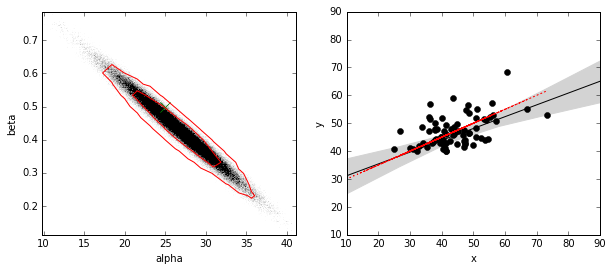

In [225]:
pymc_trace3 = [S3.trace('alpha3')[:],
              S3.trace('beta3')[:],
              S3.trace('tau3_yi')[:]]
alpha3_median =  np.median(S3.trace('alpha3')[:])
alpha3_33 = np.percentile(S3.trace('alpha3')[:], 33)
alpha3_67 = np.percentile(S3.trace('alpha3')[:], 67)
beta3_median =  np.median(S3.trace('beta3')[:])
beta3_33 = np.percentile(S3.trace('beta3')[:], 33)
beta3_67 = np.percentile(S3.trace('beta3')[:], 67)
fitter3 = pymc.MAP(model3)
fitter3.fit(iterlim=1000)
alpha3_map = np.float(fitter3.alpha3.value)
beta3_map = np.float(fitter3.beta3.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha3_map), ',{0:5.3f}'.format(beta3_map)
print "alpha values around median: {0:5.3f}".format(alpha3_median), " -{0:5.3f}".format(alpha3_median-alpha3_33), "+{0:5.3f}".format(alpha3_67-alpha3_median)
print "beta values around median: {0:5.3f}".format(beta3_median), " -{0:5.3f}".format(beta3_median-beta3_33), "+{0:5.3f}".format(beta3_67-beta3_median)
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace3,alpha3_map,beta3_map)
BIC3 =  fitter3.BIC
print 'BIC= ', BIC3
y_fit3 = alpha3_map + xdata1[limit]*beta3_map

The use of a truncated normal prior recovers a slope that is closer to the correct answer (now to within 2$\sigma$). It is also a better fit to the data (using the BIC).

Let us check if the shape of the prior on alpha makes a big difference?

In [24]:
alpha4 = pymc.Normal('alpha4', 25, 1.0e-3)

@pymc.stochastic(observed=False)
def beta4(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma4_yi = pymc.Uniform('sigma4_yi',0,100, value=ydata1_err[limit])
@pymc.deterministic 
def tau4_yi(sigma4_yi=sigma4_yi): 
            return 1./sigma4_yi**2.  

    
# Define the form of the model and likelihood
@pymc.deterministic
def y_model4(x4=xdata1[limit], alpha4=alpha4, beta4=beta4):
    fit = alpha4 + beta4*x4
    return fit

y4 = pymc.TruncatedNormal('y4', y_model4, tau4_yi, 40,110,observed=True, value=ydata1[limit])
# package the full model in a dictionary
model4 = dict(alpha4=alpha4, beta4=beta4, tau4_yi=tau4_yi,
              y_model4=y_model4, y4=y4)

In [25]:
S4 = pymc.MCMC(model4)
S4.use_step_method(AdaptiveMetropolis,S4.alpha4)
S4.use_step_method(AdaptiveMetropolis,S4.beta4)
S4.sample(iter=1000000, burn=100000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 357.7 sec

alpha and beta values at maximum: 25.593 ,0.452
alpha values around median: 26.984  -1.682 +1.681
beta values around median: 0.422  -0.036 +0.036
BIC=  424.372730708


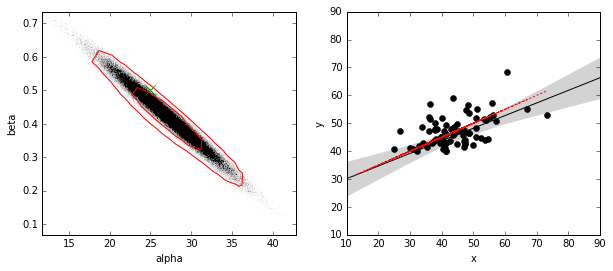

In [218]:
pymc_trace4= [S4.trace('alpha4')[:],
              S4.trace('beta4')[:],
              S4.trace('tau4_yi')[:]]
alpha4_median =  np.median(S4.trace('alpha4')[:])
alpha4_33 = np.percentile(S4.trace('alpha4')[:], 33)
alpha4_67 = np.percentile(S4.trace('alpha4')[:], 67)
beta4_median =  np.median(S4.trace('beta4')[:])
beta4_33 = np.percentile(S4.trace('beta4')[:], 33)
beta4_67 = np.percentile(S4.trace('beta4')[:], 67)
fitter4 = pymc.MAP(model4)
fitter4.fit(iterlim=1000)
alpha4_map = np.float(fitter4.alpha4.value)
beta4_map = np.float(fitter4.beta4.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha4_map), ',{0:5.3f}'.format(beta4_map)
print "alpha values around median: {0:5.3f}".format(alpha4_median), " -{0:5.3f}".format(alpha4_median-alpha4_33), "+{0:5.3f}".format(alpha4_67-alpha4_median)
print "beta values around median: {0:5.3f}".format(beta4_median), " -{0:5.3f}".format(beta4_median-beta4_33), "+{0:5.3f}".format(beta4_67-beta4_median)
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace4,alpha4_map,beta4_map)
BIC4 =  fitter4.BIC
print 'BIC= ', BIC4
y_fit4 = alpha4_map + xdata1[limit]*beta4_map

At this point, it does not appear that the choice of prior on alpha makes a huge difference.

Note that the original data is drawn (on x) from a Gaussian. But up until now, we never place any prior on x. What happens if we do? The next model uses a Gaussian distribution to represent the underlying x-data. Prior to this, no prior was specified, and so it was an uninformative uniform prior by default.

Note that we need to increase our sampling by a lot (10 times).

In [30]:
# Define the variables needed for the routine, with their prior distributions
alpha5 = pymc.Normal('alpha5', 25, 1.0e-3)

# The prior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf
    
@pymc.stochastic(observed=False)
def beta5(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma5_yi = pymc.Uniform('sigma5_yi',0,100, value=ydata1_err[limit])
@pymc.deterministic 
def tau5_yi(sigma5_yi=sigma5_yi): 
            return 1./sigma5_yi**2.  
    
xi5 = pymc.Normal('xi5', mu=40, tau=1/(10.**2),value=xdata1[limit]) #Now we are going to make sure x is a Normal

# Define the form of the model and likelihood
@pymc.deterministic
def y_model5(x=xi5, alpha5=alpha5, beta5=beta5):
    fit = alpha5+ beta5*x
    return fit

#x4 = pymc.Normal('x4', xi4, 1000000.0,value=xdata1[limit], observed=True) #x still has no error
y5 = pymc.TruncatedNormal('y5', y_model5,tau5_yi, 40,110,observed=True, value=ydata1[limit])
model5 = dict(alpha5=alpha5, beta5=beta5, y_model5=y_model5, tau5_yi=tau5_yi,xi5=xi5,y5=y5)

In [31]:
S5 = pymc.MCMC(model5) 
# Force the use of AdaptiveMetropolis step method 
S5.use_step_method(AdaptiveMetropolis,S5.alpha5)
S5.use_step_method(AdaptiveMetropolis,S5.beta5)
S5.sample(10000000, 1000000,200) 

 [-                 3%                  ] 338060 of 10000000 complete in 162.1 sec

/usr/local/anaconda/lib/python2.7/site-packages/pymc/utils.py:800: RuntimeWarning: invalid value encountered in subtract
  diff = ly - lx
/usr/local/anaconda/lib/python2.7/site-packages/pymc/utils.py:802: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(diff >= 0):


 [-----------------100%-----------------] 10000000 of 10000000 complete in 4573.5 sec

alpha and beta values at maximum: -55.208 ,2.461
alpha values around median: 22.725  -2.339 +2.298
beta values around median: 0.554  -0.052 +0.053
BIC=  640.754864956


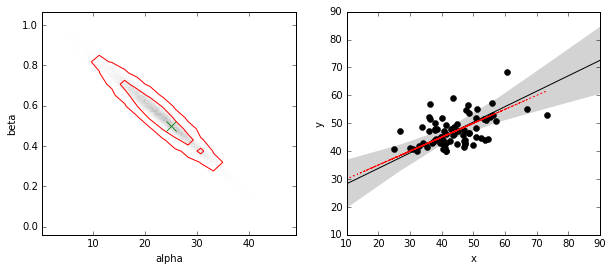

In [219]:
pymc_trace5 = [S5.trace('alpha5')[:],
               S5.trace('beta5')[:],
               S5.trace('tau5_yi')[:]]
alpha5_median =  np.median(S5.trace('alpha5')[:])
alpha5_33 = np.percentile(S5.trace('alpha5')[:], 33)
alpha5_67 = np.percentile(S5.trace('alpha5')[:], 67)
beta5_median =  np.median(S5.trace('beta5')[:])
beta5_33 = np.percentile(S5.trace('beta5')[:], 33)
beta5_67 = np.percentile(S5.trace('beta5')[:], 67)
fitter5 = pymc.MAP(model5)
fitter5.fit(iterlim=1000)
alpha5_map = np.float(fitter5.alpha5.value)
beta5_map = np.float(fitter5.beta5.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha5_map), ',{0:5.3f}'.format(beta5_map)
print "alpha values around median: {0:5.3f}".format(alpha5_median), " -{0:5.3f}".format(alpha5_median-alpha5_33), "+{0:5.3f}".format(alpha5_67-alpha5_median)
print "beta values around median: {0:5.3f}".format(beta5_median), " -{0:5.3f}".format(beta5_median-beta5_33), "+{0:5.3f}".format(beta5_67-beta5_median)
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace5,alpha5_median,beta5_median)
BIC5 =  fitter5.BIC
print 'BIC= ', BIC5
y_fit5 = alpha5_median + xdata1[limit]*beta5_median

Notice two important things: **1** is that the slope $\beta$ is now recovered to within 1 $\sigma$ (almost). **2** the BIC went way up. This is because MAP is no longer working. In other words, the maximum of the likelihood is not representative of the right locationin the posterior as described by the full posterior PDF. In this case, the MAP estimates of the parameter values are useless and the BIC is meaningless.

Now, compare them all:

# Summary of Analysis of Dataset 1 (with y errors)

(15, 70)

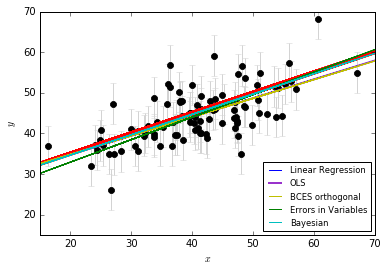

In [230]:
y_hat = theta_true[0] + theta_true[1]*xtrue
plt.errorbar(xdata1,ydata1,xerr=xdata1_err,yerr=ydata1_err,fmt='o',color='lightgrey')
plt.plot(xdata1, ydata1, 'ok')
plt.plot(xtrue,y_hat, linewidth=4, color='r' )
plt.plot(xdata1,y_fit,label="Linear Regression", color = 'b')
plt.plot(x_pred2[:,1], y_pred, '-', label="OLS",color='darkorchid', linewidth=2)
plt.plot(xdata1,y_fit_bces,'-k',label="BCES orthogonal",color='y')
plt.plot(xdata1,y_fit_eiv,'-k',label="Errors in Variables",color='g')
plt.plot(xdata1,y_fit1,'-k',label="Bayesian",color='c')
plt.legend(loc='best',fontsize='small')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(15,70)
plt.ylim(15,70)

(34, 70)

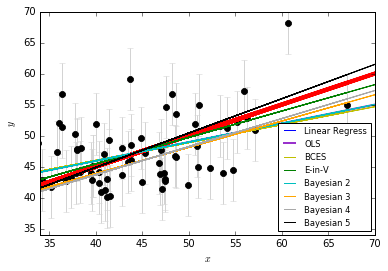

In [229]:
plt.errorbar(xdata1[limit],ydata1[limit],xerr=xdata1_err[limit],yerr=ydata1_err[limit],fmt='o',color='lightgrey')
plt.plot(xdata1[limit], ydata1[limit], 'ok')
plt.plot(xdata1,y_hat, color='r',linewidth = 4)
plt.plot(xdata1[limit],y_fit_wlim,label="Linear Regress", color = 'b')
plt.plot(x_pred2_wlim[:,1], y_pred_wlim, '-', label="OLS",color='darkorchid', linewidth=2)
plt.plot(xdata1[limit],y_fit_bces_wlim,'-k',label="BCES",color='y')
plt.plot(xdata1[limit],y_fit_eiv_wlim,'-k',label="E-in-V",color='g')
plt.plot(xdata1[limit],y_fit2,'-k',label="Bayesian 2",color='c')
plt.plot(xdata1[limit],y_fit3,'-k',label="Bayesian 3",color='orange')
plt.plot(xdata1[limit],y_fit4,'-k',label="Bayesian 4 ",color='darkgrey')
plt.plot(xdata1[limit],y_fit5,'-k',label="Bayesian 5 ",color='black')
plt.legend(loc='best',fontsize='small')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(34,70)
plt.ylim(34,70)

So on the truncated data, **only** the Bayesian model which includes the error on $y$, the distribution in $x$, and the truncation in $y$ returns credible intervals which cover the truth.

This example highlights the perils and power of Bayesian analyses. Credible intervals generally do not guarantee coverage around the true parameter values. In this example, that coverage is only guaranteed when the Bayesian model matches the model which generates the data. Of course it is important to recongnize that most of the model parameters are still free parameters (e.g., $\alpha$ and $\beta$).

Note that Errors-in-Variables does nearly as well as the Bayesian technique. E-in-V is much faster to measure and very convenient.

Now add errors to the x-coordinate:

# Data 2

### Add noise to x (and keep noise on y)

In [45]:
#Add some outliers
#s = np.random.standard_t(0.5,size=len(xdata))
#xdata = xdata + s
#option 1 is variable errors defined on their own 
#while (x_std < 25):
#    x_std = 30*np.random.random(1)
#print x_std
#option 2 is variable errors drawn from Gaussian of fixed width
ydata2 = ydata1
ydata2_err = ydata1_err
x_std = 15
xdata2 = np.random.normal(xtrue,x_std)
xdata2_err = np.zeros(len(xtrue)) + x_std


Now, let's mess with this data even more. For instance, most of Astronomy has flux-limited data (i.e., out instruments can only observe data down to some noise limit). So let's apply a cut to the data (on these x and y-values).

### Truncate the data on y

In [46]:
limit2 = np.where(((ydata2 > 40) & (ydata2 < 100)))[0]
keep2 =  np.random.randint(0, len(xtrue),size=len(limit2))

Let's plot the data and see how it evolves:

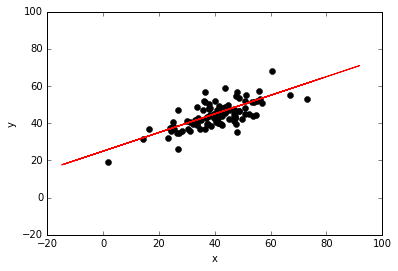

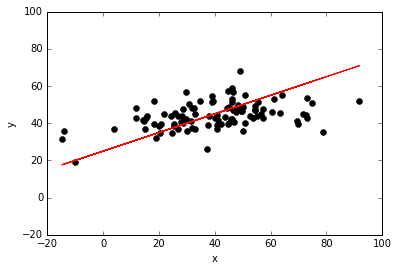

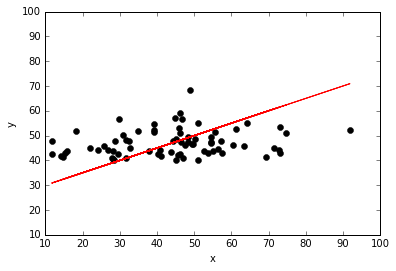

In [47]:
plt.plot(xdata1, ydata1, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-20,100)
plt.ylim(-20,100)
y_hat = theta_true[0] + theta_true[1]*xdata2
plt.plot(xdata2,y_hat,color='r')
plt.show()
plt.plot(xdata2, ydata2, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-20,100)
plt.ylim(-20,100)
y_hat = theta_true[0] + theta_true[1]*xdata2
plt.plot(xdata2,y_hat,color='r')
plt.show()
plt.plot(xdata2[limit2], ydata2[limit2], 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(10,100)
plt.ylim(10,100)
y_hat = theta_true[0] + theta_true[1]*xdata2[limit]
plt.plot(xdata2[limit2],y_hat,color='r')

How does linear
regression do on the newly scatter data? How about flux limits? **Bad**

Not surprisingly, they identify a nearly flat line as a good fit to the data.

# Begin the statistical analyses of Data 2

### Standard frequentist techniques

In [231]:
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata2,ydata2)
print 'No flux limit: ', slope, intercept, std_err
y_fitx = intercept + slope*(xdata2)

slope, intercept, r_value, p_value, std_err = stats.linregress(xdata2[limit],ydata2[limit])
print 'With flux limit: ', slope, intercept,std_err
y_fitx_wlim = intercept + slope*(xdata2[limit])

No flux limit:  0.155417660103 38.0690743255 0.0335500791556
With flux limit:  0.0686283070518 44.1181969638 0.0369701993251


In [232]:
x = sm.add_constant(xdata2) # constant intercept term
y = ydata2
# Model: y ~ x + c
model = sm.OLS(y, x)
fitted = model.fit()
x_predx = np.linspace(x.min(), x.max(), 50)
x_pred2x = sm.add_constant(x_pred)
y_predx = fitted.predict(x_pred2)
rho = fitted.params
print 'OLS intercept and slope: ', rho

#Now on the flux limited data
x= sm.add_constant(xdata2[limit]) # constant intercept term
y = ydata2[limit]
# Model: y ~ x + c
model = sm.OLS(y, x)
fitted = model.fit()
x_predx_wlim = np.linspace(x.min(), x.max(), 50)
x_pred2x_wlim = sm.add_constant(x_pred_wlim)
y_predx_wlim = fitted.predict(x_pred2_wlim)
rho = fitted.params
print 'OLS intercept and slope (flux limited): ', rho

OLS intercept and slope:  [ 38.069   0.155]
OLS intercept and slope (flux limited):  [ 44.118   0.069]


How about OLS? **Bad**

BCES: bivariate correlated errors and intrinsic scatter. For example go to: https://github.com/rsnemmen/BCES or read: http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/9605002

BCES does well.

In [251]:
nboot = 10000
cov = np.zeros(len(xdata2_err))
a,b,erra,errb,covab=bces.bcesp(xdata2,xdata2_err,ydata2,ydata2_err,cov,nboot)
y_fitx_bces = a[3]*xdata2+b[3]
#note that the third axis of the fit contains the orthogonal constraints.
print a[3], b[3]
nboot = 10000
cov = np.zeros(len(xdata2_err[limit2]))
a,b,erra,errb,covab=bces.bcesp(xdata2[limit2],xdata2_err[limit2],ydata2[limit2],ydata2_err[limit2],cov,nboot)
y_fitx_bces_wlim = a[3]*xdata2[limit2]+b[3]
#note that the third axis of the fit contains the orthogonal constraints.
print a[3], b[3]

BCES, 10000 trials... 
2.990647 s
0.430650117309 27.1627467838
BCES, 10000 trials... 
2.776314 s
0.473324492013 26.8966461396


BCES does surprisingly well on this data. Is it luck? (try again with a different data sample)

Errors in variables, non-Bayesian. http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html
Does okay on non-flux limited data.

Optimization terminated successfully.
         Current function value: 309.548706
         Iterations: 83
         Function evaluations: 160
Errors in variables:  0.320601405337 31.2685397342


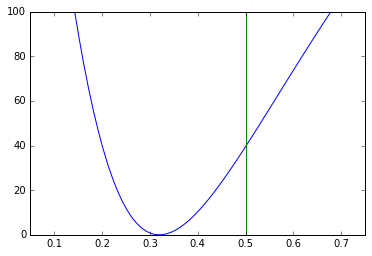

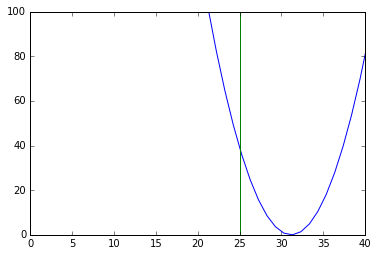

In [287]:
rho_xy = np.zeros(len(xdata2)) 
X = np.vstack((xdata1, ydata2)).T
dX = np.zeros((len(xdata2), 2, 2))
dX[:, 0, 0] = xdata2_err ** 2
dX[:, 1, 1] = ydata2_err ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * xdata2_err * ydata2_err
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[-1,1])

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])

m_fit, b_fit = get_m_b(beta_fit)
#x=np.linspace(xdata.min(),xdata.max())
y_fitx_eiv = m_fit*xdata2+b_fit
print 'Errors in variables: ', m_fit, b_fit

# plot the likelihood contour in m, b
m = np.linspace(0,1, 100)
b = np.linspace(0, 100, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)
        if np.isnan(logL[i,j]):
            logL[i, j] = -9e12
#Note, I could not get their contours to work, so I will plot likelihood ratio. Looks ok.
plt.plot(np.linspace(0,1,100),np.max(logL) -  logL[:,np.int(b_fit)])
plt.plot([theta_true[1],theta_true[1]], [0,100])
plt.ylim(0,100)
plt.xlim(0.05,0.75)
plt.show()
plt.plot(np.linspace(0,100,100),np.max(logL) -  logL[np.int(100*m_fit),:])
plt.plot([theta_true[0],theta_true[0]], [0,100])
plt.ylim(0,100)
plt.xlim(0,40)
plt.show()
#plt.contour(m, b, convert_to_stdev(logL.T),levels=(0.683, 0.955, 0.997), colors='k')
#ax.set_xlabel('slope')
#ax.set_ylabel('intercept')
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 50)


Optimization terminated successfully.
         Current function value: 226.787795
         Iterations: 107
         Function evaluations: 196
Errors in variables:  0.0776830952653 43.7218141041


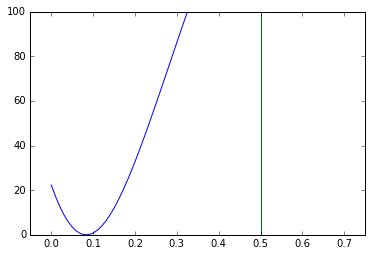

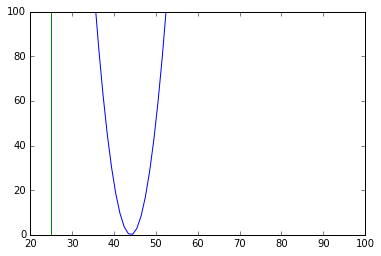

In [292]:
rho_xy = np.zeros(len(xdata2[limit2])) 
X = np.vstack((xdata2[limit2], ydata2[limit2])).T
dX = np.zeros((len(xdata2[limit2]), 2, 2))
dX[:, 0, 0] = xdata2_err[limit2] ** 2
dX[:, 1, 1] = ydata2_err[limit2] ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * xdata2_err[limit2] * ydata2_err[limit2]
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[-1, 1])
# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])

m_fit, b_fit = get_m_b(beta_fit)
y_fitx_eiv_wlim = m_fit*xdata2[limit2]+b_fit
print 'Errors in variables: ', m_fit, b_fit

# plot the likelihood contour in m, b
m = np.linspace(0,1, 100)
b = np.linspace(0, 100, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)
        if np.isnan(logL[i,j]):
            logL[i, j] = -9e12
plt.plot(np.linspace(0,1,100),np.max(logL) -  logL[:,np.int(b_fit)])
plt.plot([theta_true[1],theta_true[1]], [0,100])
plt.ylim(0,100)
plt.xlim(-0.05,0.75)
plt.show()
plt.plot(np.linspace(0,100,100),np.max(logL) -  logL[np.int(100*m_fit),:])
plt.plot([theta_true[0],theta_true[0]], [0,100])
plt.ylim(0,100)
plt.xlim(20,100)
plt.show()


Now, Bayesian. We will look first at the un-truncated data and we will ignore errors in x and apply a Uniform prior (or rather ignore the prior) in x. It fails

### Bayesian techniques

In [60]:
# Define the variables needed for the routine, with their prior distributions
alpha1x = pymc.Uniform('alpha1x', -100, 100)

@pymc.stochastic(observed=False)
def beta1x(value=0):
    return -1.5 * np.log(1 + value ** 2)

sigma1x_yi = pymc.Uniform('sigma1x_yi',0,100, value=ydata2_err)
@pymc.deterministic 
def tau1x_yi(sigma1x_yi=sigma1x_yi): 
            return 1./sigma1x_yi**2.  
    
# Define the form of the model and likelihood
@pymc.deterministic
def y_model1x(x=xdata2, alpha1x=alpha1x, beta1x=beta1x):
    fit = alpha1x + beta1x*x
    return fit

y1x = pymc.Normal('y1x', mu=y_model1x, tau=tau1x_yi, observed=True, value=ydata2)
# package the full model in a dictionary
model1x = dict(alpha1x=alpha1x, beta1x=beta1x, tau1x_yi=tau1x_yi,y_model1x=y_model1x, y1x=y1x)

In [61]:
S1x = pymc.MCMC(model1x)
S1x.use_step_method(AdaptiveMetropolis,S1x.alpha1x)
S1x.use_step_method(AdaptiveMetropolis,S1x.beta1x)
S1x.sample(iter=100000, burn=10000)

 [-----------------100%-----------------] 100000 of 100000 complete in 14.0 sec

alpha and beta values at maximum: 38.081 ,0.155
alpha values around median: 38.158  -0.464 +0.471
beta values around median: 0.153  -0.011 +0.011
BIC=  679.843090925


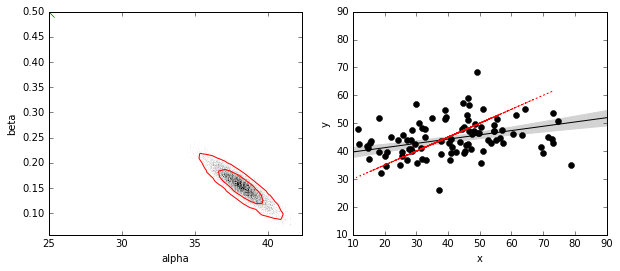

In [238]:
pymc_trace1x = [S1x.trace('alpha1x')[:],
               S1x.trace('beta1x')[:],
               S1x.trace('tau1x_yi')[:]]
alpha1x_median =  np.median(S1x.trace('alpha1x')[:])
alpha1x_33 = np.percentile(S1x.trace('alpha1x')[:], 33)
alpha1x_67 = np.percentile(S1x.trace('alpha1x')[:], 67)
beta1x_median =  np.median(S1x.trace('beta1x')[:])
beta1x_33 = np.percentile(S1x.trace('beta1x')[:], 33)
beta1x_67 = np.percentile(S1x.trace('beta1x')[:], 67)
fitter1x = pymc.MAP(model1x)
fitter1x.fit(iterlim=1000)
alpha1x_map = np.float(fitter1x.alpha1x.value)
beta1x_map = np.float(fitter1x.beta1x.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha1x_map), ',{0:5.3f}'.format(beta1x_map)
print "alpha values around median: {0:5.3f}".format(alpha1x_median), " -{0:5.3f}".format(alpha1x_median-alpha1x_33), "+{0:5.3f}".format(alpha1x_67-alpha1x_median)
print "beta values around median: {0:5.3f}".format(beta1x_median), " -{0:5.3f}".format(beta1x_median-beta1x_33), "+{0:5.3f}".format(beta1x_67-beta1x_median)
plot_MCMC_results(xdata2, ydata2, pymc_trace1x,alpha1x_median,beta1x_median)
BIC1x =  fitter1x.BIC
print 'BIC= ', BIC1x
y_fit1x = alpha1x_median + xdata2*beta1x_median

As you can see, the Bayesian model with errors only on $y$ run on the data with errors in both $y$ and $x$ fails.

Now, add x-errors to the model and apply a Gaussian prior on x. As before, we increase the sampling by a factor of 10.

In [63]:
# Intercept, slope, and intrinsic scatter 
alpha2x = pymc.Uniform('alpha2x', -100, 100)

@pymc.stochastic(observed=False)
def beta2x(value=0):
    return -1.5 * np.log(1 + value**2)

#How to handle y errors? Let's treat them as unknown with a prior given the observed y-dim variance"
#tau_yi = pymc.Gamma('tau_yi', 0.001, 0.001, value=tau0) 
#or, treat them as known and given from table.
sigma2x_yi = pymc.Uniform('sigma2x_yi',0,100, value=ydata2_err)
@pymc.deterministic 
def tau2x_yi(sigma2x_yi=sigma2x_yi): 
            return 1./sigma2x_yi**2.  
    
sigma2x_xi = pymc.Uniform('sigma2x_xi',0,100, value=xdata2_err)
@pymc.deterministic 
def tau2x_xi(sigma2x_xi=sigma2x_xi): 
            return 1./sigma2x_xi**2. 
    
#mu_x = pymc.Normal('mu_xi', 0., 1.e-6, value=xtrue.mean()) 
#tau_x = pymc.Gamma('tau_x', 0.001, 0.001, value=1./xtrue.var()) 
xi2x = pymc.Normal('xi2x', 40, 1/(10**2.0), value=xtrue) #Draw from a Gaussian described by the underlying true distribution of data

@pymc.deterministic
def y2x_model(xi2x=xi2x, alpha2x=alpha2x, beta2x=beta2x): 
    fit = alpha2x + beta2x*xi2x
    return fit

x2x = pymc.Normal('x2x', xi2x, tau2x_xi, value=xdata2, observed=True) 
y2x = pymc.Normal('y2x', y2x_model, tau2x_yi, value=ydata2, observed=True) 
# package the full model in a dictionary
model2x = dict(alpha2x=alpha2x, beta2x=beta2x, tau2x_xi=tau2x_xi,tau2x_yi=tau2x_yi,y2x_model=y2x_model, y2x=y2x,x2x=x2x)

In [68]:
M2x = pymc.MCMC(model2x) 
# Force the use of AdaptiveMetropolis step method 
M2x.use_step_method(pymc.AdaptiveMetropolis, [alpha2x,beta2x],scales={alpha2x:0.5, beta2x:0.5})
M2x.sample(10000000, 1000000,500) 

/usr/local/anaconda/lib/python2.7/site-packages/pymc/StepMethods.py:1272: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 10000000 of 10000000 complete in 857.5 sec

alpha and beta values at maximum: 25.301 ,0.468
alpha values around median: 25.610  -0.855 +0.859
beta values around median: 0.460  -0.020 +0.021
BIC=  1450.62493433


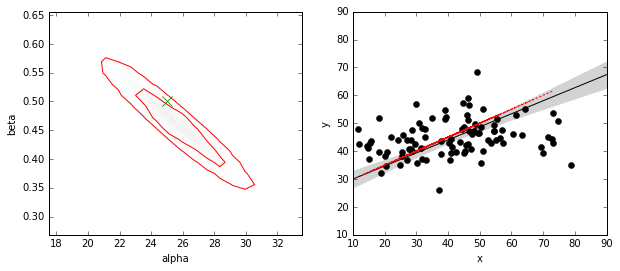

In [240]:
pymc_trace2x = [M2x.trace('alpha2x')[:],
               M2x.trace('beta2x')[:],
               M2x.trace('tau2x_yi')[:],
               M2x.trace('tau2x_xi')[:]]
alpha2x_median =  np.median(M2x.trace('alpha2x')[:])
alpha2x_33 = np.percentile(M2x.trace('alpha2x')[:], 33)
alpha2x_67 = np.percentile(M2x.trace('alpha2x')[:], 67)
beta2x_median =  np.median(M2x.trace('beta2x')[:])
beta2x_33 = np.percentile(M2x.trace('beta2x')[:], 33)
beta2x_67 = np.percentile(M2x.trace('beta2x')[:], 67)
fitter2x = pymc.MAP(model2x)
fitter2x.fit(iterlim=1000)
alpha2x_map = np.float(fitter2x.alpha2x.value)
beta2x_map = np.float(fitter2x.beta2x.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha2x_map), ',{0:5.3f}'.format(beta2x_map)
print "alpha values around median: {0:5.3f}".format(alpha2x_median), " -{0:5.3f}".format(alpha2x_median-alpha2x_33), "+{0:5.3f}".format(alpha2x_67-alpha2x_median)
print "beta values around median: {0:5.3f}".format(beta2x_median), " -{0:5.3f}".format(beta2x_median-beta2x_33), "+{0:5.3f}".format(beta2x_67-beta2x_median)
plot_MCMC_results(xdata2, ydata2, pymc_trace2x,alpha2x.value,beta2x.value)
BIC2x =  fitter2x.BIC
print 'BIC= ', BIC2x
y_fit2x = alpha2x_median + xdata2*beta2x_median

The Bayesian model which includes errors in both $y$ and $x$ gets us close to the right answer (within 2$\sigma$).

Note, I annoying swithed the model names to M (as opposed to S). 

Note: It is still not converged at 10000000 steps and 1000000 burn in. I think I should at least double this. 

Now, let's use the truncated data (in y), with x-errors and Gaussian prior on x. However, we will not use a truncated likelihood on y.

In [70]:
# Intercept, slope, and intrinsic scatter 
#alpha3x = pymc.Normal('alpha3x', 25, 1.e-2) 
alpha3x = pymc.Uniform('alpha3x', -100, 100)

@pymc.stochastic(observed=False)
def beta3x(value=0):
    return -1.5 * np.log(1 + value**2)

#How to handle y errors? Let's treat them as unknown with a prior given the observed y-dim variance"
#tau_yi = pymc.Gamma('tau_yi', 0.001, 0.001, value=tau0) 
#or, treat them as known and given from table.
sigma3x_yi = pymc.Uniform('sigma3x_yi',0,100, value=ydata2_err[limit2])
@pymc.deterministic 
def tau3x_yi(sigma3x_yi=sigma3x_yi): 
            return 1./sigma3x_yi**2.  
    
sigma3x_xi = pymc.Uniform('sigma3x_xi',0,100, value=xdata2_err[limit2])
@pymc.deterministic 
def tau3x_xi(sigma3x_xi=sigma3x_xi): 
            return 1./sigma3x_xi**2. 
    
#mu_x = pymc.Normal('mu_xi', 0., 1.e-6, value=xtrue.mean()) 
#tau_x = pymc.Gamma('tau_x', 0.001, 0.001, value=1./xtrue.var()) 
xi3x = pymc.Normal('xi3x', 40, 1/(10**2.0), value=xtrue[limit2]) #Draw from a Gaussian described by the underlying true distribution of data

@pymc.deterministic
def y_model3x(xi3x=xi3x, alpha3x=alpha3x, beta3x=beta3x): 
    fit = alpha3x + beta3x*xi3x
    return fit

x3x = pymc.Normal('x3x', xi3x, tau3x_xi, value=xdata2[limit2], observed=True) 
x3x_pred = pymc.Normal('x3x_pred', xi3x, tau3x_xi)
y3x = pymc.Normal('y3x', y_model3x, tau3x_yi, value=ydata2[limit2], observed=True) 
y3x_pred = pymc.Normal('y3x_pred', y_model3x, tau3x_yi)
model3x = dict(alpha3x=alpha3x, beta3x=beta3x,xi3x=xi3x,x3x=x3x,y3x=y3x,y_model3x=y_model3x,x3x_pred=x3x_pred,y3x_pred=y3x_pred,tau3x_xi=tau3x_xi, tau3x_yi=tau3x_yi)

In [71]:
M3x = pymc.MCMC(model3x) 
# Force the use of AdaptiveMetropolis step method 
#M1.use_step_method(pymc.AdaptiveMetropolis, [alpha,beta],scales={alpha:0.5, beta:0.5})
M3x.sample(10000000, 1000000,500) 

 [-----------------100%-----------------] 10000000 of 10000000 complete in 2910.7 sec

alpha and beta values at maximum: -24.570 ,1.729
alpha values around median: 39.007  -1.796 +1.861
beta values around median: 0.196  -0.044 +0.044
BIC=  2115.85853695


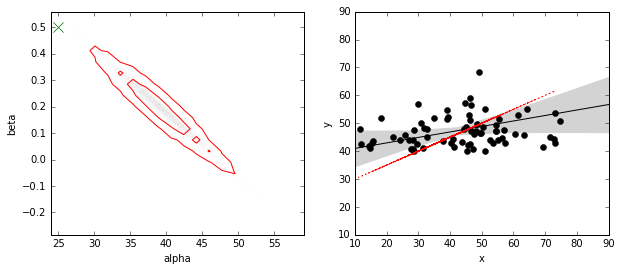

In [241]:
pymc_trace3x = [M3x.trace('alpha3x')[:],
               M3x.trace('beta3x')[:],
               M3x.trace('tau3x_yi')[:],
               M3x.trace('tau3x_xi')[:]]
alpha3x_median =  np.median(M3x.trace('alpha3x')[:])
alpha3x_33 = np.percentile(M3x.trace('alpha3x')[:], 33)
alpha3x_67 = np.percentile(M3x.trace('alpha3x')[:], 67)
beta3x_median =  np.median(M3x.trace('beta3x')[:])
beta3x_33 = np.percentile(M3x.trace('beta3x')[:], 33)
beta3x_67 = np.percentile(M3x.trace('beta3x')[:], 67)
fitter3x = pymc.MAP(model3x)
fitter3x.fit(iterlim=1000)
alpha3x_map = np.float(fitter3x.alpha3x.value)
beta3x_map = np.float(fitter3x.beta3x.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha3x_map), ',{0:5.3f}'.format(beta3x_map)
print "alpha values around median: {0:5.3f}".format(alpha3x_median), " -{0:5.3f}".format(alpha3x_median-alpha3x_33), "+{0:5.3f}".format(alpha3x_67-alpha3x_median)
print "beta values around median: {0:5.3f}".format(beta3x_median), " -{0:5.3f}".format(beta3x_median-beta3x_33), "+{0:5.3f}".format(beta3x_67-beta3x_median)
plot_MCMC_results(xdata2[limit2], ydata2[limit2], pymc_trace3x,alpha3x_median,beta3x_median)
BIC3x =  fitter3x.BIC
print 'BIC= ', BIC3x
y_fit3x = alpha3x_median + xdata2[limit2]*beta3x_median

So, the model with errors in $y$ and $x$, a Gaussian prior on $y$ and $x$ (which was used in the generation of the data) fails on the truncated data!.

So let us add a truncated Normal to the likelihood on the data $y$. 

At the same time, I will explicitly implement a **Uniform** prior on $x$. Otherwise, I will keep the errors on $x$ and $y$ in the model.

In [141]:
# Intercept, slope, and intrinsic scatter 
alpha4x = pymc.Uniform('alpha4x', -100,100,value=2)
@pymc.stochastic(observed=False)
def beta4x(value=0):
    return -1.5 * np.log(1 + value**2)

#How to handle y errors? Let's treat them as unknown with a prior given the observed y-dim variance"
#tau_yi = pymc.Gamma('tau_yi', 0.001, 0.001, value=tau0) 
#or, treat them as known and given from table.
sigma4x_yi = pymc.Uniform('sigma4x_yi',0,100, value=ydata2_err[limit2])
@pymc.deterministic 
def tau4x_yi(sigma4x_yi=sigma4x_yi): 
            return 1./sigma4x_yi**2.  
    
sigma4x_xi = pymc.Uniform('sigma4x_xi',0,100, value=xdata2_err[limit2])
@pymc.deterministic 
def tau4x_xi(sigma4x_xi=sigma4x_xi): 
            return 1./sigma4x_xi**2. 

xi4x = pymc.Uniform('xi4x', 20, 100, value=xtrue[limit2]) #Draw from a Uniform described by the underlying true distribution of data

@pymc.deterministic
def y4x_model(xi4x=xi4x, alpha4x=alpha4x, beta4x=beta4x): 
    fit = alpha4x + beta4x*xi4x
    return fit

x4x = pymc.Normal('x4x', xi4x, tau4x_xi, value=xdata2[limit2], observed=True) 
x4x_pred = pymc.Normal('x4x_pred', xi4x, tau4x_xi)
y4x = pymc.TruncatedNormal('y4x', y4x_model, tau4x_yi, 40,100,observed=True, value=ydata2[limit2])
y4x_pred = pymc.TruncatedNormal('y4x_pred', y4x_model, tau4x_yi, 40,100)
model4x = dict(alpha4x=alpha4x, beta4x=beta4x,xi4x=xi4x,x4x=x4x,y4x=y4x,y4x_model=y4x_model,x4x_pred=x4x_pred,y4x_pred=y4x_pred,tau4x_xi=tau4x_xi, tau4x_yi=tau4x_yi)

Be warned, this model took me 2 hours to run.

In [143]:
M4x = pymc.MCMC(model4x) 
# Force the use of AdaptiveMetropolis step method 
M4x.use_step_method(pymc.AdaptiveMetropolis, [alpha4x,beta4x],scales={alpha4x:0.5, beta4x:0.5})
M4x.sample(10000000, 1000000,500) 

 [-----------------100%-----------------] 10000000 of 10000000 complete in 7171.2 sec

alpha and beta values at maximum: -9.454 ,1.055
alpha values around median: 34.461  -1.667 +1.600
beta values around median: 0.232  -0.031 +0.031
BIC=  2082.59186644


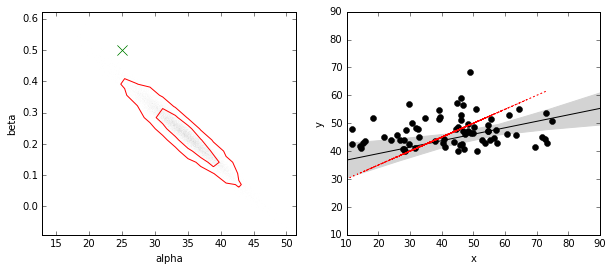

In [242]:
pymc_trace4x = [M4x.trace('alpha4x')[:],
              M4x.trace('beta4x')[:],
              M4x.trace('tau4x_yi')[:],
              M4x.trace('tau4x_xi')[:],
              M4x.trace('y4x_pred')[:],
              M4x.trace('x4x_pred')[:]]
alpha4x_median =  np.median(M4x.trace('alpha4x')[:])
alpha4x_33 = np.percentile(M4x.trace('alpha4x')[:], 33)
alpha4x_67 = np.percentile(M4x.trace('alpha4x')[:], 67)
beta4x_median =  np.median(M4x.trace('beta4x')[:])
beta4x_33 = np.percentile(M4x.trace('beta4x')[:], 33)
beta4x_67 = np.percentile(M4x.trace('beta4x')[:], 67)
fitter4x = pymc.MAP(model4x)
fitter4x.fit(iterlim=1000)
alpha4x_map = np.float(fitter4x.alpha4x.value)
beta4x_map = np.float(fitter4x.beta4x.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha4x_map), ',{0:5.3f}'.format(beta4x_map)
print "alpha values around median: {0:5.3f}".format(alpha4x_median), " -{0:5.3f}".format(alpha4x_median-alpha4x_33), "+{0:5.3f}".format(alpha4x_67-alpha4x_median)
print "beta values around median: {0:5.3f}".format(beta4x_median), " -{0:5.3f}".format(beta4x_median-beta4x_33), "+{0:5.3f}".format(beta4x_67-beta4x_median)
plot_MCMC_results(xdata2[limit2], ydata2[limit2], pymc_trace4x,alpha4x_median,beta4x_median)
BIC4x =  fitter4x.BIC
print 'BIC= ', BIC4x
y_fit4x = alpha4x_median + xdata2[limit2]*beta4x_median

So in this case, the only part of the model that is incorrect is the distribution on $x$. Let us switch back to a Gaussian on $x$:

In [145]:
# Intercept, slope, and intrinsic scatter 
alpha5x = pymc.Uniform('alpha5x', -100,100,value=2)
@pymc.stochastic(observed=False)
def beta5x(value=0):
    return -1.5 * np.log(1 + value**2)

#How to handle y errors? Let's treat them as unknown with a prior given the observed y-dim variance"
#tau_yi = pymc.Gamma('tau_yi', 0.001, 0.001, value=tau0) 
#or, treat them as known and given from table.
sigma5x_yi = pymc.Uniform('sigma5x_yi',0,100, value=ydata2_err[limit2])
@pymc.deterministic 
def tau5x_yi(sigma5x_yi=sigma5x_yi): 
            return 1./sigma5x_yi**2.  
    
sigma5x_xi = pymc.Uniform('sigma5x_xi',0,100, value=xdata2_err[limit2])
@pymc.deterministic 
def tau5x_xi(sigma5x_xi=sigma5x_xi): 
            return 1./sigma5x_xi**2. 

xi5x = pymc.Normal('xi5x', 40, 1/(10**2.0), value=xtrue[limit2]) #Draw from a Gaussian described by the underlying true distribution of data

@pymc.deterministic
def y5x_model(xi5x=xi5x, alpha5x=alpha5x, beta5x=beta5x): 
    fit = alpha5x + beta5x*xi5x
    return fit

x5x = pymc.Normal('x5x', xi5x, tau5x_xi, value=xdata2[limit2], observed=True) 
x5x_pred = pymc.Normal('x5x_pred', xi5x, tau5x_xi)
y5x = pymc.TruncatedNormal('y5x', y5x_model, tau5x_yi, 40,100,observed=True, value=ydata2[limit2])
y5x_pred = pymc.TruncatedNormal('y5x_pred', y5x_model, tau5x_yi, 40,100)
model5x = dict(alpha5x=alpha5x, beta5x=beta5x,xi5x=xi5x,x5x=x5x,y5x=y5x,y5x_model=y5x_model,x5x_pred=x5x_pred,y5x_pred=y5x_pred,tau5x_xi=tau5x_xi, tau5x_yi=tau5x_yi)

Be warned, this too me 2 hours to run.

In [146]:
M5x = pymc.MCMC(model5x) 
# Force the use of AdaptiveMetropolis step method 
M5x.use_step_method(pymc.AdaptiveMetropolis, [alpha5x,beta5x],scales={alpha5x:0.5, beta5x:0.5})
M5x.sample(10000000, 1000000,500) 

 [-----------------100%-----------------] 10000000 of 10000000 complete in 8010.5 sec

alpha and beta values at maximum: -53.571 ,2.229
alpha values around median: 22.423  -2.584 +2.528
beta values around median: 0.547  -0.055 +0.059
BIC=  2082.01077558


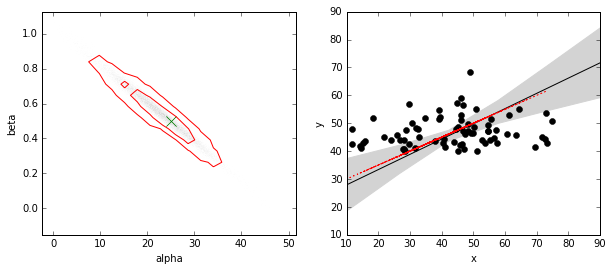

In [244]:
pymc_trace5x = [M5x.trace('alpha5x')[:],
              M5x.trace('beta5x')[:],
              M5x.trace('tau5x_yi')[:],
              M5x.trace('tau5x_xi')[:],
              M5x.trace('y5x_pred')[:],
              M5x.trace('x5x_pred')[:]]
alpha5x_median =  np.median(M5x.trace('alpha5x')[:])
alpha5x_33 = np.percentile(M5x.trace('alpha5x')[:], 33)
alpha5x_67 = np.percentile(M5x.trace('alpha5x')[:], 67)
beta5x_median =  np.median(M5x.trace('beta5x')[:])
beta5x_33 = np.percentile(M5x.trace('beta5x')[:], 33)
beta5x_67 = np.percentile(M5x.trace('beta5x')[:], 67)
fitter5x = pymc.MAP(model5x)
fitter5x.fit(iterlim=1000)
alpha5x_map = np.float(fitter5x.alpha5x.value)
beta5x_map = np.float(fitter5x.beta5x.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha5x_map), ',{0:5.3f}'.format(beta5x_map)
print "alpha values around median: {0:5.3f}".format(alpha5x_median), " -{0:5.3f}".format(alpha5x_median-alpha5x_33), "+{0:5.3f}".format(alpha5x_67-alpha5x_median)
print "beta values around median: {0:5.3f}".format(beta5x_median), " -{0:5.3f}".format(beta5x_median-beta5x_33), "+{0:5.3f}".format(beta5x_67-beta5x_median)
plot_MCMC_results(xdata2[limit2], ydata2[limit2], pymc_trace5x,alpha5x_median,beta5x_median)
BIC5x =  fitter5x.BIC
print 'BIC= ', BIC5x
y_fit5x = alpha5x_median + xdata2[limit2]*beta5x_median

So, the BIC for the Truncated Normal is better than that for the regular Normal. 

Let us double check to make sure the MCMC sampled xs and ys resemble the real data. This is an excellent (and highly intuitive) test of whether the model is sensible.

### Look at the forward model (does it represent the observed data?)

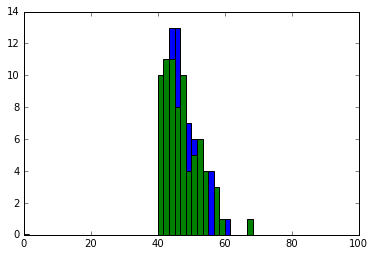

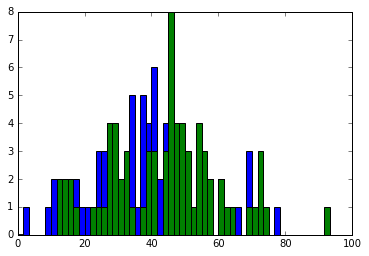

(10, 90)

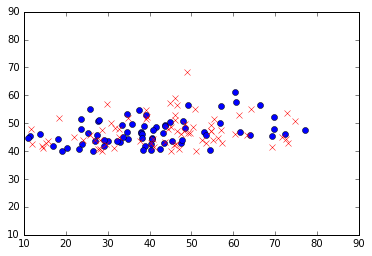

In [148]:
y_pred = M5x.trace('y5x_pred')[1000]
x_pred = M5x.trace('x5x_pred')[1000]
x_bins=60
plt.hist(y_pred, range=[0, 100], bins=x_bins)
plt.hist(ydata2[limit2], range=[0, 100], bins=x_bins)
plt.show()
plt.hist(x_pred, range=[0, 100], bins=x_bins)
plt.hist(xdata2[limit2], range=[0, 100], bins=x_bins)
plt.show()
plt.plot(x_pred, y_pred,'o')
plt.plot(xdata2[limit2], ydata2[limit2],'rx')
plt.xlim(10,90)
plt.ylim(10,90)

# Summarize the analyses on Dataset 2 (with errors on x and y)

(15, 75)

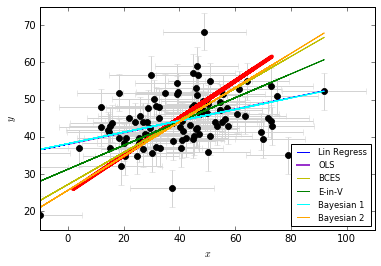

In [294]:
y_hat = theta_true[0] + theta_true[1]*xtrue
plt.errorbar(xdata2,ydata2,xerr=xdata2_err,yerr=ydata2_err,fmt='o',color='lightgrey')
plt.plot(xdata2, ydata2, 'ok')
plt.plot(xtrue,y_hat, color='r',linewidth = 4)
plt.plot(xdata2,y_fitx,label="Lin Regress", color = 'b')
plt.plot(x_pred2x[:,1], y_predx, '-', label="OLS",color='darkorchid', linewidth=2)
plt.plot(xdata2,y_fitx_bces,'-k',label="BCES",color='y')
plt.plot(xdata2,y_fitx_eiv,'-k',label="E-in-V",color='g')
plt.plot(xdata2,y_fit1x,'-k',label="Bayesian 1 ",color='cyan')
plt.plot(xdata2,y_fit2x,'-k',label="Bayesian 2 ",color='orange')
plt.legend(loc='best',fontsize='small')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-10,110)
plt.ylim(15,75)

(35, 75)

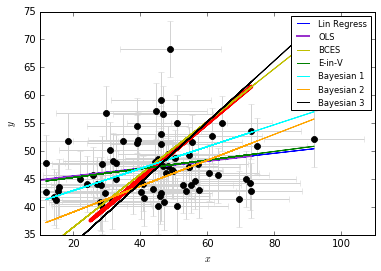

In [253]:
y_hat = theta_true[0] + theta_true[1]*xtrue[limit2]

plt.errorbar(xdata2[limit2],ydata2[limit2],xerr=xdata2_err[limit2],yerr=ydata2_err[limit2],fmt='o',color='lightgrey')
plt.plot(xdata2[limit2], ydata2[limit2], 'ok')
plt.plot(xtrue[limit2],y_hat, color='r',linewidth = 4)
plt.plot(xdata2[limit2],y_fitx_wlim,label="Lin Regress", color = 'b')
plt.plot(x_pred2x_wlim[:,1], y_predx_wlim, '-', label="OLS",color='darkorchid', linewidth=2)
plt.plot(xdata2[limit2],y_fitx_bces_wlim,'-k',label="BCES",color='y')
plt.plot(xdata2[limit2],y_fitx_eiv_wlim,'-k',label="E-in-V",color='g')
plt.plot(xdata2[limit2],y_fit3x,'-k',label="Bayesian 1 ",color='cyan')
plt.plot(xdata2[limit2],y_fit4x,'-k',label="Bayesian 2 ",color='orange')
plt.plot(xdata2[limit2],y_fit5x,'-k',label="Bayesian 3 ",color='black')

plt.legend(loc='best',fontsize='small')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(10,110)
plt.ylim(35,75)

On the most challenging dataset (errors in x and y with truncation in y), The lone survivors of being able to recover the input slope and intercept are the Bayesian technique which models the errors in x, the errors in y, and also the distribution in x; and BCES.

# Overall summary

Bayesian techniques can be quite powerful. However, complicated models deserve serious testing like what we have done here. However, the BCES frequentist technique worked just as well and is just as well grounded in statistical theory. Arguably, the Errors-in-Variables frequentist technique should have worked in both cases and I am surprised it didn't. Is there a bug in my implementation code? If not, maybe in astroML? I have some digging to do.

So what do you choose, frequentist or Bayesian? Both? I would argue that modern high performance computing gives the scientist much more freedom to explore this question through Monte Carlos experimentation. One of the things I like most about the Bayesian approach is that it requires you to very carefully consider your data (through your likelihood). The truncation example here is enlightening from that perspective. However, Bayesian analyses live and die by their priors. So think hard.

### This is formally the end of the tutorial. The stuff below is a work in progess.

In [ ]:
def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[0] for s in S.stochastics])
    logp = np.zeros(traces.shape)
    for i in range(len(logp)):
        logp[i] = -M.func(traces[i])
    return logp


def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


In [ ]:
trace2 = np.vstack([M2.trace('alpha')[:],
          M2.trace('beta')[:]])#,
#              M.trace('tau_yi')[:],
#              M.trace('tau_xi')[:]],
#              M.trace('y_pred')[:],
#              M.trace('x_pred')[:]]
logp2 = get_logp(M2, model2)        
BF2, dBF2 = estimate_bayes_factor(trace2, logp2, r=0.02)
print BF2, dBF2

In [ ]:
logp1 = get_logp(M, model1)
BF1, dBF1 = estimate_bayes_factor(M.trace, logp1, r=0.02)

In [ ]:
from scipy.special import gamma
from sklearn.neighbors import BallTree
from astroML.density_estimation import GaussianMixture1D
trace1 = np.vstack([M1.trace('alpha')[:],
          M1.trace('beta')[:]])#,
#              M.trace('tau_yi')[:],
#              M.trace('tau_xi')[:]],
#              M.trace('y_pred')[:],
#              M.trace('x_pred')[:]]
logp1 = get_logp(M1, model1)        
BF1, dBF1 = estimate_bayes_factor(trace1, logp1, r=0.02)
print BF1, dBF1

Next up is an emcee approach...not done yet.

In [ ]:
Model_parameter_names = [r"$\alpha$", r"$\beta$", r"$\sigma_x$",r"$\sigma_y$" ]

#-----------------------------------------------------------------------------#
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
#    alpha,beta,gamma,sigma_sq = p
#    alpha,beta,gamma  = p
    alpha,beta, sigma_x, sigma_y = p
    # We're using only uniform priors, and only eps has a lower bound
#    if sigma_sq <= 0:
#        return -np.inf
    if (alpha <= 0):
        return -np.inf 
    if (alpha >= 100):
        return -np.inf   
#    (norm.cdf(np.random.normal(0.5, 1)) >= np.random.uniform(0.5, 1)):
#        return -np.inf 
    if ((np.abs(sigma_x - norm.rvs(loc=0.05,scale = 0.01)) >= 0.01) or sigma_x < 0):
        return -np.inf       
    if ((np.abs(sigma_y - norm.rvs(loc=0.02,scale = 0.01)) >= 0.01) or sigma_y < 0):
        return -np.inf 
    return 0.5*np.log((1.0 + beta**2))



#-----------------------------------------------------------------------------#
def lnlike(p, x, y):
    alpha,beta,sigma_x, sigma_y = p
#    alpha,beta,gamma = p
    
    model = alpha + beta*(x)
    
#    denom = sigma_sq + sigma_y**2 + (beta*sigma_x)**2 + (gamma*sigma_z)**2
    denom = sigma_y**2 + (beta*sigma_x)**2 
    lp = -0.5*np.sum((y - model)**2/denom + np.log(denom) + np.log(2.0*np.pi))
    
    return lp


#-----------------------------------------------------------------------------#
def lnprob(p, x, y):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y)

#-----------------------------------------------------------------------------#

In [ ]:
nWalker = 10
nDim = 4
nThreads = 10
nSteps = 100000
nBurnSteps = 10000

In [ ]:
p_initial_guesses = [25, 0.5,20,10]
p0 = [(p_initial_guesses + 0.01*np.random.rand(nDim)) for i in range(nWalker)]

In [ ]:
sampler = emcee.EnsembleSampler(nWalker,nDim,lnprob, args=(xdata_lim,ydata_lim), threads=nThreads)

In [ ]:
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps, storechain=True)

In [ ]:
fig1 = plt.figure(figsize=(7.5, 10))
for j in range(nDim):
    ax = fig1.add_subplot(nDim,1,j+1)
    ax.plot(np.array([sampler.chain[:,i,j] for i in range(nBurnSteps)]), 'k', alpha = 0.3)
    ax.set_ylabel(Model_parameter_names[j], fontsize = 30)
plt.xlabel('Steps', fontsize = 20)
fig1.show()